In [1]:
import torch
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def gen_line(xsize=1,ysize=1):
    p1=2*(xsize+ysize)*float(torch.rand(1)[0])
    circ=2*(xsize+ysize)
    if p1<xsize:
        x1=p1
        y1=0
        p2=xsize+(xsize+2*ysize)*torch.rand(1)
    elif p1<xsize+ysize:
        x1=xsize
        y1=p1-xsize
        p2=(xsize+ysize+(2*xsize+ysize)*torch.rand(1))%circ
    elif p1<2*xsize+ysize:
        x1=2*xsize+ysize-p1
        y1=ysize
        p2=(2*xsize+ysize+(xsize+2*ysize)*torch.rand(1))%circ
    else:
        x1=0
        y1=circ-p1
        p2=(2*xsize+ysize)*torch.rand(1)
    p2=float(p2[0])
    if p2<xsize+ysize:
        x2=min(p2,xsize)
        y2=max(0,p2-xsize)
    else:
        x2=max(2*xsize+ysize-p2,0)
        y2=min(ysize,circ-p2)
    return torch.tensor((x1,y1)),torch.tensor((x2,y2))

(0, 5)

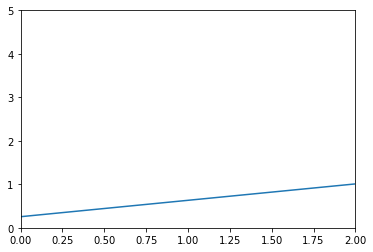

In [2]:
xsize=2
ysize=5
p1,p2=gen_line(xsize=xsize,ysize=ysize)
plt.plot((p1[0],p2[0]),(p1[1],p2[1]))
plt.xlim(0,xsize)
plt.ylim(0,ysize)

In [3]:
def gen_samples(p0,p1,xsize=1,ysize=1,nsamp=1):
    pdif=p1-p0
    a,b=torch.tensor([pdif[1],-pdif[0]])
    xns=[]
    yns=[]
    for _ in range(nsamp):
        new_point=torch.rand(2)*torch.tensor([xsize,ysize])
        sign=torch.sign(a*(new_point[0]-p0[0])+b*(new_point[1]-p0[1]))
        xns.append(new_point)
        yns.append(sign)
    xns=torch.stack(xns)
    yns=torch.stack(yns)
    return xns,yns

In [18]:
def plot_orig(p1,p2,xns,yns,line=True):
    cmap, norm = mcolors.from_levels_and_colors([-1,0, 1], ['red', 'blue'])
    plt.scatter(xns[:,0],xns[:,1],c=yns[:],cmap=cmap)
    if line:
        plt.plot((p1[0],p2[0]),(p1[1],p2[1]),lw=5,color="black")
    plt.xlim(0,1)
    plt.ylim(0,1)

In [31]:
def perc_model(xn,w):
    return torch.sign(torch.matmul(xn,w))
def loss_fn(yns_mod,yns_true):
    return torch.count_nonzero(yns_mod!=yns_true)

In [7]:
def aug_xn(xn):
    return torch.cat([torch.ones(xn.size(0)).unsqueeze(1),xn],dim=1)

In [65]:
def pocket_PLA(xns,yns,n_epochs=1000,plot=False):
    w=torch.rand(3)*torch.tensor([1,2,1])+torch.tensor([0,-1,0])
    datasize=xns.size(0)
    #best_loss=loss_fn(torch.tensor([perc_model(xn,w) for xn in xns]),yns)
    best_loss=loss_fn(perc_model(xns,w),yns)
    best_w=w
    if plot:
        plot_count=0
    n=0
    finish=False
    while True:
        mismatch=False
        perm=torch.randperm(datasize)
        xns,yns=xns[perm],yns[perm]
        for ind,(xn,yn) in enumerate(zip(xns,yns)):
            if perc_model(xn,w)!=yn:
                w+=yn*xn
                n+=1
                mismatch=True
                if n>=n_epochs:
                    finish=True
                    break
        if n>=n_epochs or not mismatch:
            break
                
            loss=loss_fn(perc_model(xns[ind:],w),yns[ind:])
            if loss<best_loss:
                best_loss=loss
                best_w=w
        if plot and n%10==0:
            plot_count+=1
            xpoints=np.linspace(0,xsize,2)
            ypoints=(-c-a*xpoints)/b
            xpos=0.1+0.1*(plot_count%9)
            ypos=(-c-a*xpos)/b
            plt.plot(xpoints,ypoints,"--",color="green",lw=1)
            plt.text(xpos,ypos,plot_count)
    return best_w



[0. 2.] tensor([ 1.0739, -0.3519], dtype=torch.float64)
Samples:


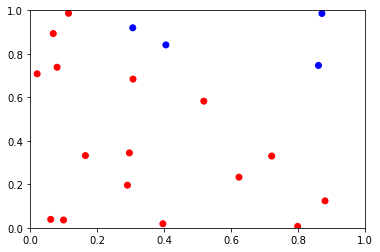

Separator:


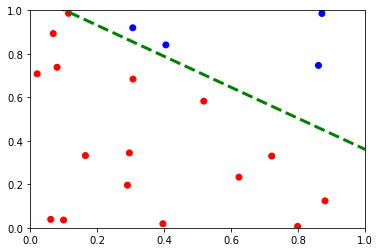

True distribution:


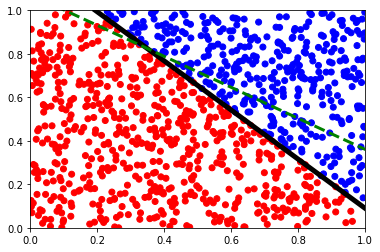

In [79]:
p1,p2=gen_line()
n=1000
ntrain=20
xns,yns=gen_samples(p1,p2,nsamp=n)
perm=torch.randperm(n)
xn_data,yn_data=xns[perm[:ntrain]],yns[perm[:ntrain]]
#plot_orig(p1,p2,xns,yns)
c,a,b=pocket_PLA(aug_xn(xn_data),yn_data,plot=False,n_epochs=200)
xpoints=np.linspace(0,xsize,2)
ypoints=(-c-a*xpoints)/b
print(xpoints,ypoints)
print("Samples:")
plot_orig(p1,p2,xn_data,yn_data,line=False)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
print("Separator:")
plot_orig(p1,p2,xn_data,yn_data,line=False)
plt.plot(xpoints,ypoints,"--",color="green",lw=3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
print("True distribution:")
plot_orig(p1,p2,xns,yns)
plt.plot(xpoints,ypoints,"--",color="green",lw=3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

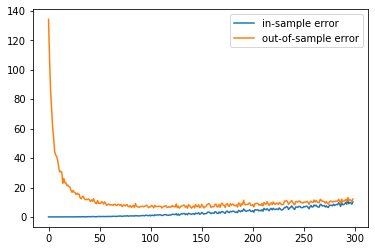

In [71]:
def in_vs_out_er(repeat=10,n=1000,n_epochs=100):
    
    p1,p2=gen_line()
    in_er_ar,out_er_ar=[],[]
    xntrue,yntrue=gen_samples(p1,p2,nsamp=n)
    xntrue=aug_xn(xntrue)
    for ntrain in range(1,n):
        in_er=0
        out_er=0
        for _ in range(repeat):
            xn_data,yn_data=gen_samples(p1,p2,nsamp=ntrain)
            xn_data=aug_xn(xn_data)
            perm=torch.randperm(n)
            #plot_orig(p1,p2,xns,yns)
            w=pocket_PLA(xn_data,yn_data,plot=False,n_epochs=n_epochs)
            in_er+=loss_fn(perc_model(xn_data,w),yn_data)
            out_er+=loss_fn(perc_model(xntrue,w),yntrue)
        in_er=in_er/repeat
        out_er=out_er/repeat
        in_er_ar.append(in_er)
        out_er_ar.append(out_er)
    return in_er_ar,out_er_ar
in_ers,out_ers=in_vs_out_er(n=300,n_epochs=200,repeat=200)
plt.plot(in_ers,label="in-sample error")
plt.plot(out_ers,label="out-of-sample error")
plt.legend()